In [1]:
import pandas as pd
import numpy as np

## Carregando os dados

Utilizamos aqui duas bases disponíveis no *kaggle*: uma para a construção e validação do modelo (chamaremos de **dados**) e a outra como forma de teste que será utilizada para submissão no *kaggle* (chamaremos de **dados_teste**).

In [2]:
dados = pd.read_csv('train.csv', sep=",")
dados_teste = pd.read_csv('test.csv', sep=",")

In [3]:
dados.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Retirando as colunas que não interessam

In [4]:
dados = dados.drop(columns=['PassengerId', 'Name', 'Cabin'])

## Modelando

Dividimos a base inicial de treino para validação do modelo ($80\%$ para treino e $20\%$ para teste).


In [5]:
from pycaret.classification import *

In [6]:
titanic_treino = dados.sample(frac=0.8, random_state=123)
titanic_teste = dados.drop(titanic_treino.index)

titanic_treino.reset_index(inplace=True, drop=True)
titanic_teste.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(titanic_treino.shape))
print('Unseen Data For Predictions ' + str(titanic_teste.shape))

Data for Modeling: (713, 9)
Unseen Data For Predictions (178, 9)


Ficamos assim com 713 registros para treinar o modelo e 178 registros para teste.

O próximo passo é construir o *setup* para nosso modelo. Utilizaremos a normalização dos dados, onde no próprio setup ele imputará a mediana para os valores numéricos faltantes e a moda para os dados categóricos. Removeremos também as variáveis correlacionadas. Existem outras opções de pré-processamento que podem ser consultadas em *?setup*. 

Esse comando também realiza uma divisão na base de treino para realizar a validação com os modelos que serão treinados, evitando assim o *overfitting*. Nessa etapa de pré-processamento ele já cria variáveis *dummy* para as entradas categóricas.

In [7]:
titanic_modelo = setup(data = titanic_treino, target='Survived', session_id=123,
                      normalize=True,
                      numeric_imputation='median',
                      remove_multicollinearity=True)

,Description,Value
0,session_id,123
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(713, 9)"
5,Missing Values,True
6,Numeric Features,2
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


O comando *compare models* utiliza todos os modelos presentes nesse pacote e realiza um modelagem inicial testando todos eles e retornando os resultados, destacando aqueles com melhor desempenho.

In [8]:
models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8337,0.8587,0.6751,0.8464,0.7482,0.6269,0.6380,0.7820
gbc,Gradient Boosting Classifier,0.8278,0.8559,0.6652,0.8402,0.7375,0.6129,0.6260,0.0200
lightgbm,Light Gradient Boosting Machine,0.8236,0.8522,0.7079,0.8031,0.7483,0.6136,0.6206,0.1740
xgboost,Extreme Gradient Boosting,0.8056,0.8491,0.7190,0.7502,0.7330,0.5804,0.5820,0.2400
rf,Random Forest Classifier,0.7995,0.8389,0.6751,0.7649,0.7146,0.5611,0.5661,0.0570
lda,Linear Discriminant Analysis,0.7936,0.8316,0.6860,0.7407,0.7100,0.5505,0.5535,0.0060
lr,Logistic Regression,0.7856,0.8250,0.6649,0.7383,0.6971,0.5323,0.5364,0.4280
ridge,Ridge Classifier,0.7856,0.0000,0.6810,0.7274,0.7016,0.5349,0.5373,0.0040
dt,Decision Tree Classifier,0.7796,0.7725,0.6974,0.7073,0.7000,0.5264,0.5284,0.0040
ada,Ada Boost Classifier,0.7756,0.7920,0.6374,0.7247,0.6739,0.5051,0.5106,0.0220


In [9]:
print(models)

Por motivo de comparação escolheremos o  *XGBoost* para realizar a nossa modelagem.

## Especificando o nosso modelo

Com a função *create_model*, criamos o modelo esfecificando o algoritmo a ser utilizado e aqui utilizaremos 5 folds nesse processo.

In [10]:
#modelo
titanic_xgb = create_model('xgboost', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8000,0.8769,0.7027,0.7429,0.7222,0.5662,0.5667
1,0.8400,0.8968,0.7838,0.7838,0.7838,0.6568,0.6568
2,0.7800,0.7911,0.7027,0.7027,0.7027,0.5281,0.5281
3,0.8000,0.8426,0.7027,0.7429,0.7222,0.5662,0.5667
4,0.7576,0.8348,0.6757,0.6757,0.6757,0.4821,0.4821
Mean,0.7955,0.8484,0.7135,0.7296,0.7213,0.5599,0.5601
SD,0.0272,0.0365,0.0367,0.0372,0.0356,0.0575,0.0575


Podemos também realizar a tunagem dos hiperparâmetros. Basta utilizar o *tune_model* e especificar qual métrica será utilizada no processo de otimização. Utilizaremos o *AUC*.

In [11]:
#tunando
tune_titanic_xgb = tune_model(titanic_xgb, optimize='AUC', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7000,0.8915,0.9189,0.5574,0.6939,0.4325,0.4854
1,0.6700,0.8904,0.9459,0.5303,0.6796,0.3907,0.4626
2,0.6400,0.7834,0.8378,0.5082,0.6327,0.3190,0.3580
3,0.6600,0.8252,0.8108,0.5263,0.6383,0.3439,0.3728
4,0.6061,0.8422,0.8919,0.4853,0.6286,0.2801,0.3415
Mean,0.6552,0.8465,0.8811,0.5215,0.6546,0.3532,0.4040
SD,0.0313,0.0410,0.0501,0.0240,0.0268,0.0535,0.0584


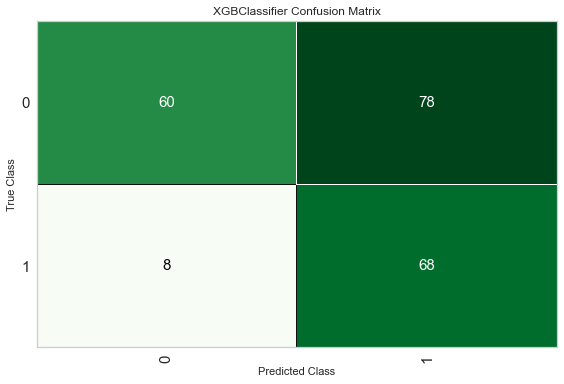

In [12]:
plot_model(tune_titanic_xgb, plot = 'confusion_matrix')

Na matrix de confusão podemos perceber que o modelo construído ainda necessita de ajustes, especificamente nos falsos positivos.


Outra vantagem do *pycaret* está no comando *evaluate_model*. Com ele podemos olhar para o nosso modelo de várias formas, com esse único comando. É fantástico!

In [13]:
evaluate_model(tune_titanic_xgb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Testando

Vamos testar o modelo construído e verificar como ele se comporta. Utilizaremos a função *predict_model* e passaremos dois objetos: o modelo construído e a base de teste.

In [14]:
predicoes = predict_model(tune_titanic_xgb, data=titanic_teste)

In [15]:
from pycaret.utils import check_metric
check_metric(predicoes['Survived'], predicoes['Label'], metric = 'AUC')

0.6949

O desempenho nos dados de teste ficou abaixo em relação aos dados de treino.

In [16]:
predicoes.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Label,Score
0,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,0.7284
1,1,1,female,35.0,1,0,113803,53.1000,S,1,0.9996
2,1,3,female,27.0,0,2,347742,11.1333,S,1,0.9771
3,0,3,female,14.0,0,0,350406,7.8542,S,1,0.9906
4,0,3,male,2.0,4,1,382652,29.1250,Q,0,0.8845


A função *finalize_model* realiza a finalização do modelo construído.

In [17]:
modelo_final = finalize_model(tune_titanic_xgb)

## SUBMISSÃO NO KAGGLE

Para realizar a submissão no kaggle, faremos a predição utilizando o nosso modelo e os a base chamada de *dados_teste*. Em seguida, filtraremos apenas a coluna *PassengerId* e a coluna *Label*, que contém nossas previsões.

In [18]:
titanic_submission = predict_model(modelo_final, data = dados_teste)
titanic_submission.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Label,Score
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.9867
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0.6012
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,0.6801
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,0.9291
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.9562


In [19]:
titanic_submission = titanic_submission[['PassengerId', 'Label']]

In [20]:
titanic_submission.head()

,PassengerId,Label
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1


In [21]:
titanic_submission = titanic_submission.rename(columns={'Label':'Survived'})

Finalizamos acima renomeando as colunas como *Label* e *Survived*, conforme exigido pelo *kaggle* para a submissão. Salvaremos o arquivo para posterior submissão.

In [22]:
titanic_submission.to_csv('gender_submission', index=False)

## SOBRE O PYCARET

O *pycaret* mostrou-se como sendo uma ótima ferramenta para economizar tempo e talvez, permitir a realização de uma modelagem inicial objetivando a escolha de um 'melhor' algoritmo, para um posterior estudo mais detalhado. Ela faz tudo isso de forma dinâmica e sem muito esforço, permitindo também que o próprio usuário escolha outras formas de pré-processamento, modelagem e visualização dos resultados. Vale a pena conhecer.